In [1]:
# Libraries to import
from folium.plugins import Search
import numpy as np
import pandas as pd
import pygeos
import pyrosm
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import requests
import os

In [2]:
osm_tn_url = "https://osmit-estratti.wmcloud.org/dati/poly/province/pbf/022_Trento_poly.osm.pbf"

In [3]:
# If data is not downloaded yet, request from ISTAT
if not os.path.exists('../data/Limiti01012021_g'):
    # download the data
    import requests
    import zipfile
    import io
    zip_file_url = 'https://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012021_g.zip'
    # request the file
    r = requests.get(zip_file_url, verify=False)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # unzip the file
    z.extractall("../data/")

In [4]:
trentino = gpd.read_file("../data/Trentino/schools/schools.geojson",
                         geometry="geometry")

In [5]:
trento_download_pbf_url = "https://osmit-estratti.wmcloud.org/dati/poly/province/pbf/022_Trento_poly.osm.pbf"
# download the data
# request the file
r = requests.get(trento_download_pbf_url, allow_redirects=True)
# save the file
open('../data/trento.pbf', 'wb').write(r.content)

41527847

In [6]:
# Initialize the OSM object
osm = pyrosm.OSM("../data/trento.pbf")

In [7]:
custom_filter = {'amenity': True,
                 'shop': True,
                 'tourism': True,
                 'leisure': True,
                 'sport': True}
pois = osm.get_pois(custom_filter)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [8]:
pois = pois[['lat', 'lon', 'name', 'amenity', 'shop', 'tourism',
             'leisure', 'opening_hours', 'phone', 'website',
             'internet_access', 'geometry']]

pois['category'] = pois['amenity'].fillna(pois['shop']).fillna(
    pois['tourism']).fillna(pois['leisure'])
pois.drop(['amenity', 'shop', 'tourism', 'leisure'], axis=1, inplace=True)

In [9]:
def categorize(type):
    if type in ['bar', 'cafe', 'restaurant', 'restaurant;bar',
                'restaurant;cafe', 'fast_food', 'food_court',
                'ice_cream', 'supermarket', 'bakery',
                'greengrocer', 'mall', 'marketplace']:
        return "Food"
    elif type in ['clinic', 'dentist', 'doctors',
                  'hospital', 'pharmacy']:
        return "Healthcare"
    elif type in ['training', 'gym', 'ski_school', 'sailing_school', 'aquatics_centre',
                  'dive_centre', 'horse_riding', 'fitness_centre', 'fitness_station', 'ice_rink',
                  'dojo', 'pitch', 'schoolyard', 'stadium', 'swimming_area', 'swimming_pool']:
        return "Sport"
    elif type in ['theatre', 'museum', 'arts_centre', 'gallery',
                  'cinema', 'library', 'zoo', 'planetarium', 'artwork', 'books',
                  'music_school', 'music_venue', 'public_bookcase']:
        return "Culture"
    elif type in ["typography", 'tipography', 'drinking_water',
                  'stationery', 'copyshop', 'printing', 'stationery']:
        return "Utilities"
    elif type in ['outdoor_seating', 'park', 'picnic_site', 'picnic_table']:
        return "Outdoor"
    else:
        return ""


# Apply category to each type of amenity
pois['type'] = [categorize(x) for x in pois['category']]

# Remove amenities with no type
pois = pois[pois['type'] != ""]

# Convert polygons into points, by collecting only its representative
pois['geometry'] = pois['geometry'].representative_point()

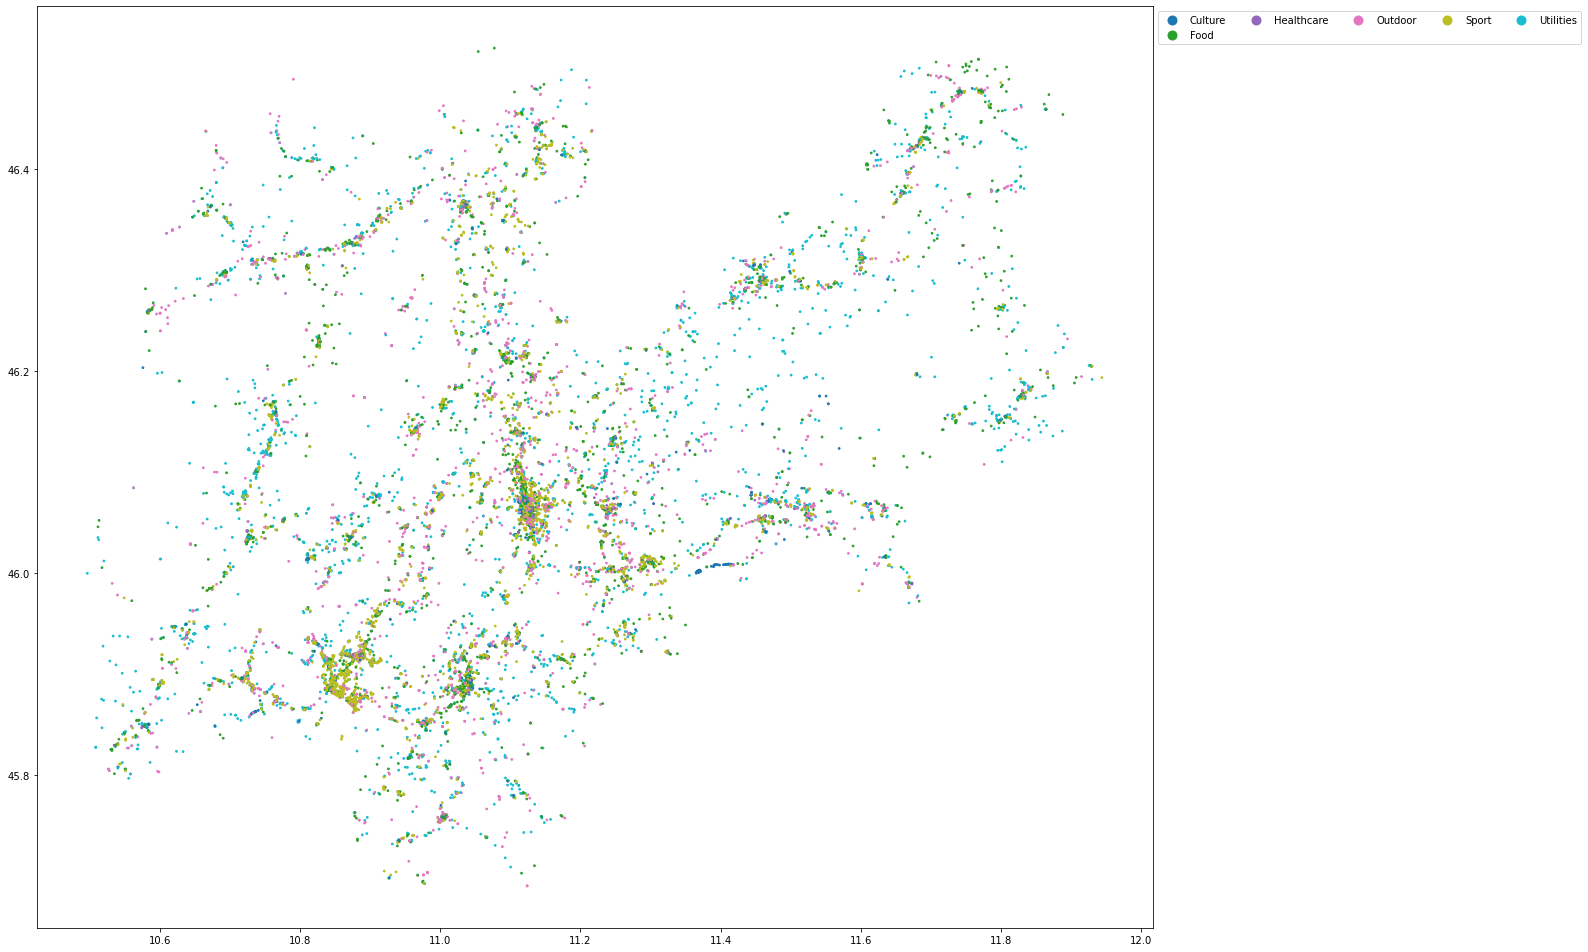

In [10]:
# Plot
ax = pois.plot(column='type', markersize=3, figsize=(20, 20), legend=True,
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
plt.show()

In [11]:
# Import bus and train stations
# Train stations
train_stations = pd.read_csv(
    "../data/Trentino/transports/trenitalia_stations.csv")
train_stations = gpd.GeoDataFrame(train_stations,
                                  geometry=gpd.points_from_xy(train_stations.lon,
                                                              train_stations.lat))

train_stations.rename(columns={'Stazione': 'name'}, inplace=True)
train_stations = train_stations[['name', 'lat', 'lon']]
train_stations['type'] = "Transports"
train_stations['category'] = "train"

# Bus stops
bus_stops = pd.read_csv("../data/Trentino/transports/urban_stops.txt")
bus_stops_2 = pd.read_csv("../data/Trentino/transports/extraurban_stops.txt")
bus_stops_2['wheelchair_boarding'] = np.nan
bus_stops = pd.concat([bus_stops, bus_stops_2])
bus_stops = bus_stops[['stop_name', 'stop_lat', 'stop_lon']]
bus_stops.rename(columns={'stop_name': 'name',
                          'stop_lat': 'lat',
                          'stop_lon': 'lon'}, inplace=True)
bus_stops['type'] = "Transports"
bus_stops['category'] = "bus"

transports = pd.concat([train_stations, bus_stops])
transports = gpd.GeoDataFrame(transports,
                              geometry=gpd.points_from_xy(transports.lon,
                                                          transports.lat))

pois = pd.concat([pois, transports])
# TASKS
# 1. Get all points around 500 meters from every school
# 2. Color schools in red, everything else with mapped colours

In [12]:
schools = gpd.read_file("../data/Trentino/schools/schools.geojson", crs=4326)

schools['neighbour'] = schools['geometry'].to_crs(
    32632).buffer(500).to_crs(4326)

In [13]:
# Get only POIs within the buffers
pois = pois.reset_index(drop=True)

schools_neighbour = gpd.GeoDataFrame(schools['neighbour'],
                                     geometry=schools['neighbour'],
                                     crs=4326).dissolve(aggfunc=sum)

selection = []
for i in range(len(pois)):
    if pois.loc[i, 'geometry'].within(schools_neighbour['geometry'][0]):
        selection.append(i)
        print(i)

selection = list(set(selection))
pois = pois.iloc[selection].reset_index(drop=True)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  return getattr(obj, f)()


0
1
2
3
4
5
6
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
34
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
73
74
75
77
79
80
81
82
83
84
85
86
87
88
89
91
92
93
94
99
100
101
102
103
105
106
107
108
109
110
111
112
113
114
115
116
118
119
123
124
128
129
130
132
134
135
136
137
139
140
141
142
143
144
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
171
172
173
174
175
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
198
199
200
203
204
205
206
207
210
216
218
228
232
233
237
243
244
245
246
247
248
249
250
251
252
256
257
258
259
264
268
269
270
271
272
273
274
275
276
280
281
282
283
284
285
286
287
291
292
293
298
299
300
301
302
304
306
318
323
330
331
333
335
336
337
338
342
343
344
367
369
370
371
376
378
379
387
388
391
392
393
400
401
402
406
417
418
421
422
427
428
429
430
431
433
435
436
437
438
439
440
441
442
443
444
445
447
448
450
451
452
454
455
457
458


In [14]:
icons = {
    'Culture': {'icon': 'university', 'color': 'pink', 'name': 'Cultura'},
    'Transports': {'icon': 'bus', 'color': 'lightblue', 'name': 'Trasporti'},
    'Utilities': {'icon': 'wrench', 'color': 'lightgray', 'name': 'Utilità'},
    'Food': {'icon': 'cutlery', 'color': 'lightred', 'name': 'Ristorazione'},
    'Healthcare': {'icon': 'medkit', 'color': 'lightgreen', 'name': 'Salute'},
    'Sport': {'icon': 'bicycle', 'color': 'orange', 'name': 'Sport'},
    'Outdoor': {'icon': 'tree', 'color': 'green', 'name': 'Aree verdi'}
}

traduction = {
    'aquatics_centre': 'Centro acquatico',
    'arts_centre': 'Centro artistico',
    'artwork': "Opera d'arte",
    'bakery': "Panificio",
    'bar': "Bar",
    'books': "Libreria",
    'bus': "Fermata del bus",
    'cafe': "Bar",
    'cinema': "Cinema",
    'clinic': "Clinica",
    'copyshop': "Copisteria",
    'dentist': "Dentista",
    'doctors':"Dottore",
    'dojo': "Dojo",
    'drinking_water': "Acqua potabile",
    'fast_food': "Fast food",
    'fitness_centre': "Centro sportivo",
    'fitness_station': "Attrezzatura sportiva all'aperto",
    'food_court': "Cortile alimentare",
    'gallery': "Galleria d'arte",
    'greengrocer': "Fruttivendolo",
    'horse_riding': "Equitazione",
    'hospital': "Ospedale",
    'ice_cream': "Gelateria",
    'ice_rink': "Pista di pattinaggio",
    'library': "Biblioteca",
    'mall': "Centro commerciale",
    'marketplace': "Mercato",
    'museum': "Museo",
    'music_school': "Scuola di musica",
    'music_venue': "Locale per eventi musicali",
    'outdoor_seating': "Posto a sedere",
    'park': "Parco",
    'pharmacy': "Farmacia",
    'picnic_site': "Area picnic",
    'picnic_table': "Tavolo per picnic",
    'pitch': "Campo da gioco",
    'printing': "Copisteria",
    'public_bookcase': "Libreria pubblica",
    'restaurant': "Ristorante",
    'restaurant;cafe': "Ristorante/caffè",
    'schoolyard': "Cortile scolastico",
    'ski_school': "Scuola di sci",
    'stadium': "Stadio",
    'stationery': "Cartoleria",
    'supermarket': "Supermercato",
    'swimming_area': "Piscina",
    'swimming_pool': "Piscina",
    'theatre': "Teatro",
    'tipography': "Copisteria",
    'train': "Fermata del treno",
    'typography': "Copisteria",
    'opening_hours': "Orari di apertura",
    'phone': 'Telefono',
    'website': "Sito web",
    'internet_access': "Accesso a Internet",
    'category': "Luogo",
    'type': "Categoria",
    'Healthcare':'Salute',
    'Food': 'Ristorazione',
    'Sport':'Sport',
    'Culture':'Cultura',
    'Transports': 'Trasporti',
    'Outdoor':'Aree verdi',
    'Utilities':'Utilità',
    'time': 'Distanza (min)',
    'distance': 'Distanza (metri)'
}

pois = pois.fillna(np.nan).replace([np.nan], [None])

In [15]:
def get_pois_within_buffer(p, pois):
    # Getting the neighbour of the school
    buffer = p['neighbour']
    # Getting indexes of POIs around the school
    j = [i for i in range(len(pois)) if pois.loc[i, 'geometry'].within(buffer)]
    return pois.iloc[j]

def generate_complete_popup(row):
    # Open the HTML popup table
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="height: 150px; width: 280px; font-family: 'Roboto', sans-serif; padding:5px; word-wrap: break-all;">
            <tbody>
        """.format(row['Nome'])

    # Iterate over columns
    for c in ['Istituto', 'Tipo Istituto', 'Gestione',
              'Indirizzo', 'Comune', 'CAP', 'Telefono', 'Fax',
              'Email istituto', 'Email segreteria', 'Sito web']:

        # If the value is Null, don't insert it in the table
        if row[c] != None:
            if c in ['Sito web']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all; padding: 0 10px 0 0;"><a href = "https://{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif c in ['Telefono', 'Fax']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif 'Email' in c:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "mailto:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            else:  # No need for links
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(c, row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

def generate_simple_popup(row):
    # Open the HTML popup table
    if row['name'] != None:
        header = row['name']
    else:
        header = traduction[row['category']]
    
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="width: 160px; font-family: 'Roboto', sans-serif;">
            <tbody>
        """.format(header)

    # Iterate over columns
    for c in ['opening_hours','phone','website','internet_access','category','type', 'time','distance']:
        # If the value is Null, don't insert it in the table
        if row[c] != None and row[c] != "nan":
            if c in ['website']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all;"><a href = "https://{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['phone']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['category','type']:
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], traduction[row[c]]) + """
                    </tr>
                """                
            else:  # No need for links or traductions
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

In [16]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=16, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m

In [17]:
create_school_pois_map(schools.iloc[0],pois,icons)

In [18]:
# Get only POIs within the buffers
pois = pois.reset_index(drop=True)

schools_neighbour = gpd.GeoDataFrame(schools['neighbour'],
                                     geometry=schools['neighbour'],
                                     crs=4326).dissolve(aggfunc=sum)

selection = []
from tqdm import tqdm
for i in tqdm(range(len(pois))):
    if pois.loc[i, 'geometry'].within(schools_neighbour['geometry'][0]):
        selection.append(i)

selection = list(set(selection))
pois = pois.iloc[selection].reset_index(drop=True)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  return getattr(obj, f)()
100%|██████████| 8206/8206 [00:40<00:00, 202.96it/s]


In [19]:
custom_filter = {'amenity': True,
                 'shop': True,
                 'tourism': True,
                 'leisure': True,
                 'sport': True}
pois = osm.get_pois(custom_filter)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [20]:
pois = pois[['lat', 'lon', 'name', 'amenity', 'shop', 'tourism',
             'leisure', 'opening_hours', 'phone', 'website',
             'internet_access', 'geometry']]

pois['category'] = pois['amenity'].fillna(pois['shop']).fillna(
    pois['tourism']).fillna(pois['leisure'])
pois.drop(['amenity', 'shop', 'tourism', 'leisure'], axis=1, inplace=True)

In [21]:
def categorize(type):
    if type in ['bar', 'cafe', 'restaurant', 'restaurant;bar',
                'restaurant;cafe', 'fast_food', 'food_court',
                'ice_cream', 'supermarket', 'bakery',
                'greengrocer', 'mall', 'marketplace']:
        return "Food"
    elif type in ['clinic', 'dentist', 'doctors',
                  'hospital', 'pharmacy']:
        return "Healthcare"
    elif type in ['training', 'gym', 'ski_school', 'sailing_school', 'aquatics_centre',
                  'dive_centre', 'horse_riding', 'fitness_centre', 'fitness_station', 'ice_rink',
                  'dojo', 'pitch', 'schoolyard', 'stadium', 'swimming_area', 'swimming_pool']:
        return "Sport"
    elif type in ['theatre', 'museum', 'arts_centre', 'gallery',
                  'cinema', 'library', 'zoo', 'planetarium', 'artwork', 'books',
                  'music_school', 'music_venue', 'public_bookcase']:
        return "Culture"
    elif type in ["typography", 'tipography', 'drinking_water',
                  'stationery', 'copyshop', 'printing', 'stationery']:
        return "Utilities"
    elif type in ['outdoor_seating', 'park', 'picnic_site', 'picnic_table']:
        return "Outdoor"
    else:
        return ""


# Apply category to each type of amenity
pois['type'] = [categorize(x) for x in pois['category']]

# Remove amenities with no type
pois = pois[pois['type'] != ""]

# Convert polygons into points, by collecting only its representative
pois['geometry'] = pois['geometry'].representative_point()

In [22]:
# Import bus and train stations
# Train stations
train_stations = pd.read_csv(
    "../data/Trentino/transports/trenitalia_stations.csv")
train_stations = gpd.GeoDataFrame(train_stations,
                                  geometry=gpd.points_from_xy(train_stations.lon,
                                                              train_stations.lat))

train_stations.rename(columns={'Stazione': 'name'}, inplace=True)
train_stations = train_stations[['name', 'lat', 'lon']]
train_stations['type'] = "Transports"
train_stations['category'] = "train"

# Bus stops
bus_stops = pd.read_csv("../data/Trentino/transports/urban_stops.txt")
bus_stops_2 = pd.read_csv("../data/Trentino/transports/extraurban_stops.txt")
bus_stops_2['wheelchair_boarding'] = np.nan
bus_stops = pd.concat([bus_stops, bus_stops_2])
bus_stops = bus_stops[['stop_name', 'stop_lat', 'stop_lon']]
bus_stops.rename(columns={'stop_name': 'name',
                          'stop_lat': 'lat',
                          'stop_lon': 'lon'}, inplace=True)
bus_stops['type'] = "Transports"
bus_stops['category'] = "bus"

transports = pd.concat([train_stations, bus_stops])
transports = gpd.GeoDataFrame(transports,
                              geometry=gpd.points_from_xy(transports.lon,
                                                          transports.lat))

pois = pd.concat([pois, transports])
# TASKS
# 1. Get all points around 500 meters from every school
# 2. Color schools in red, everything else with mapped colours

In [23]:
schools = gpd.read_file("../data/Trentino/schools/schools.geojson", crs=4326)

schools['neighbour'] = schools['geometry'].to_crs(
    32632).buffer(1000).to_crs(4326)

In [24]:
# Get only POIs within the buffers
pois = pois.reset_index(drop=True)

schools_neighbour = gpd.GeoDataFrame(schools['neighbour'],
                                     geometry=schools['neighbour'],
                                     crs=4326).dissolve(aggfunc=sum)

selection = []
from tqdm import tqdm
for i in tqdm(range(len(pois))):
    if pois.loc[i, 'geometry'].within(schools_neighbour['geometry'][0]):
        selection.append(i)

selection = list(set(selection))
pois = pois.iloc[selection].reset_index(drop=True)

C:\Users\auror\anaconda3\envs\geospatial\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  return getattr(obj, f)()
100%|██████████| 16184/16184 [00:58<00:00, 277.42it/s]


In [25]:
icons = {
    'Culture': {'icon': 'university', 'color': 'pink', 'name': 'Cultura'},
    'Transports': {'icon': 'bus', 'color': 'lightblue', 'name': 'Trasporti'},
    'Utilities': {'icon': 'wrench', 'color': 'lightgray', 'name': 'Utilità'},
    'Food': {'icon': 'cutlery', 'color': 'lightred', 'name': 'Ristorazione'},
    'Healthcare': {'icon': 'medkit', 'color': 'lightgreen', 'name': 'Salute'},
    'Sport': {'icon': 'bicycle', 'color': 'orange', 'name': 'Sport'},
    'Outdoor': {'icon': 'tree', 'color': 'green', 'name': 'Aree verdi'}
}

traduction = {
    'aquatics_centre': 'Centro acquatico',
    'arts_centre': 'Centro artistico',
    'artwork': "Opera d'arte",
    'bakery': "Panificio",
    'bar': "Bar",
    'books': "Libreria",
    'bus': "Fermata del bus",
    'cafe': "Bar",
    'cinema': "Cinema",
    'clinic': "Clinica",
    'copyshop': "Copisteria",
    'dentist': "Dentista",
    'doctors':"Dottore",
    'dojo': "Dojo",
    'drinking_water': "Acqua potabile",
    'fast_food': "Fast food",
    'fitness_centre': "Centro sportivo",
    'fitness_station': "Attrezzatura sportiva all'aperto",
    'food_court': "Cortile alimentare",
    'gallery': "Galleria d'arte",
    'greengrocer': "Fruttivendolo",
    'horse_riding': "Equitazione",
    'hospital': "Ospedale",
    'ice_cream': "Gelateria",
    'ice_rink': "Pista di pattinaggio",
    'library': "Biblioteca",
    'mall': "Centro commerciale",
    'marketplace': "Mercato",
    'museum': "Museo",
    'music_school': "Scuola di musica",
    'music_venue': "Locale per eventi musicali",
    'outdoor_seating': "Posto a sedere",
    'park': "Parco",
    'pharmacy': "Farmacia",
    'picnic_site': "Area picnic",
    'picnic_table': "Tavolo per picnic",
    'pitch': "Campo da gioco",
    'printing': "Copisteria",
    'public_bookcase': "Libreria pubblica",
    'restaurant': "Ristorante",
    'restaurant;cafe': "Ristorante/caffè",
    'schoolyard': "Cortile scolastico",
    'ski_school': "Scuola di sci",
    'stadium': "Stadio",
    'stationery': "Cartoleria",
    'supermarket': "Supermercato",
    'swimming_area': "Piscina",
    'swimming_pool': "Piscina",
    'theatre': "Teatro",
    'tipography': "Copisteria",
    'train': "Fermata del treno",
    'typography': "Copisteria",
    'opening_hours': "Orari di apertura",
    'phone': 'Telefono',
    'website': "Sito web",
    'internet_access': "Accesso a Internet",
    'category': "Luogo",
    'type': "Categoria",
    'Healthcare':'Salute',
    'Food': 'Ristorazione',
    'Sport':'Sport',
    'Culture':'Cultura',
    'Transports': 'Trasporti',
    'Outdoor':'Aree verdi',
    'Utilities':'Utilità',
    'time': 'Distanza (min)',
    'distance': 'Distanza (metri)'
}

pois = pois.fillna(np.nan).replace([np.nan], [None])

In [26]:
def get_pois_within_buffer(p, pois):
    # Getting the neighbour of the school
    buffer = p['neighbour']
    # Getting indexes of POIs around the school
    j = [i for i in range(len(pois)) if pois.loc[i, 'geometry'].within(buffer)]
    return pois.iloc[j]

def generate_complete_popup(row):
    # Open the HTML popup table
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="height: 150px; width: 280px; font-family: 'Roboto', sans-serif; padding:5px; word-wrap: break-all;">
            <tbody>
        """.format(row['Nome'])

    # Iterate over columns
    for c in ['Istituto', 'Tipo Istituto', 'Gestione',
              'Indirizzo', 'Comune', 'CAP', 'Telefono', 'Fax',
              'Email istituto', 'Email segreteria', 'Sito web']:

        # If the value is Null, don't insert it in the table
        if row[c] != None:
            if c in ['Sito web']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all; padding: 0 10px 0 0;"><a href = "https://{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif c in ['Telefono', 'Fax']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif 'Email' in c:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "mailto:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            else:  # No need for links
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(c, row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

def generate_simple_popup(row):
    # Open the HTML popup table
    if row['name'] != None:
        header = row['name']
    else:
        header = traduction[row['category']]
    
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="width: 160px; font-family: 'Roboto', sans-serif;">
            <tbody>
        """.format(header)

    # Iterate over columns
    for c in ['opening_hours','phone','website','internet_access','category','type', 'time','distance']:
        # If the value is Null, don't insert it in the table
        if row[c] != None and row[c] != "nan":
            if c in ['website']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all;"><a href = "https://{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['phone']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['category','type']:
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], traduction[row[c]]) + """
                    </tr>
                """                
            else:  # No need for links or traductions
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

In [27]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=16, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m
create_school_pois_map(schools.iloc[0],pois,icons)

In [28]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=15, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m
create_school_pois_map(schools.iloc[0],pois,icons)

In [29]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=14, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m
create_school_pois_map(schools.iloc[0],pois,icons)

In [30]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=15, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m
create_school_pois_map(schools.iloc[0],pois,icons).save("../viz/pois/"+str(0)+".html")

In [31]:
import json
with open("../data/traduzioni.json","r") as f:
    traduction = json.loads(f)

TypeError: the JSON object must be str, bytes or bytearray, not TextIOWrapper

In [32]:
import json
with open("../data/traduzioni.json","r") as f:
    traduction = json.load(f)

In [33]:
traduction

{'aquatics_centre': 'Centro acquatico',
 'arts_centre': 'Centro artistico',
 'artwork': "Opera d'arte",
 'bakery': 'Panificio',
 'bar': 'Bar',
 'books': 'Libreria',
 'bus': 'Fermata del bus',
 'cafe': 'Bar',
 'cinema': 'Cinema',
 'clinic': 'Clinica',
 'copyshop': 'Copisteria',
 'dentist': 'Dentista',
 'doctors': 'Dottore',
 'dojo': 'Dojo',
 'drinking_water': 'Acqua potabile',
 'fast_food': 'Fast food',
 'fitness_centre': 'Centro sportivo',
 'fitness_station': "Attrezzatura sportiva all'aperto",
 'food_court': 'Cortile alimentare',
 'gallery': "Galleria d'arte",
 'greengrocer': 'Fruttivendolo',
 'horse_riding': 'Equitazione',
 'hospital': 'Ospedale',
 'ice_cream': 'Gelateria',
 'ice_rink': 'Pista di pattinaggio',
 'library': 'Biblioteca',
 'mall': 'Centro commerciale',
 'marketplace': 'Mercato',
 'museum': 'Museo',
 'music_school': 'Scuola di musica',
 'music_venue': 'Locale per eventi musicali',
 'outdoor_seating': 'Posto a sedere',
 'park': 'Parco',
 'pharmacy': 'Farmacia',
 'picnic_s

In [34]:
# Libraries to import
from folium.plugins import Search
import numpy as np
import pandas as pd
import pygeos
import pyrosm
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import requests
import os

In [35]:
osm_tn_url = "https://osmit-estratti.wmcloud.org/dati/poly/province/pbf/022_Trento_poly.osm.pbf"

In [36]:
# If data is not downloaded yet, request from ISTAT
if not os.path.exists('../data/Limiti01012021_g'):
    # download the data
    import requests
    import zipfile
    import io
    zip_file_url = 'https://www.istat.it/storage/cartografia/confini_amministrativi/generalizzati/Limiti01012021_g.zip'
    # request the file
    r = requests.get(zip_file_url, verify=False)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # unzip the file
    z.extractall("../data/")

In [37]:
trentino = gpd.read_file("../data/Trentino/schools/schools.geojson",
                         geometry="geometry")

In [38]:
trento_download_pbf_url = "https://osmit-estratti.wmcloud.org/dati/poly/province/pbf/022_Trento_poly.osm.pbf"
# download the data
# request the file
r = requests.get(trento_download_pbf_url, allow_redirects=True)
# save the file
open('../data/trento.pbf', 'wb').write(r.content)

41527847

In [39]:
# Initialize the OSM object
osm = pyrosm.OSM("../data/trento.pbf")

In [40]:
custom_filter = {'amenity': True,
                 'shop': True,
                 'tourism': True,
                 'leisure': True,
                 'sport': True}
pois = osm.get_pois(custom_filter)

In [ ]:
pois = pois[['lat', 'lon', 'name', 'amenity', 'shop', 'tourism',
             'leisure', 'opening_hours', 'phone', 'website',
             'internet_access', 'geometry']]

pois['category'] = pois['amenity'].fillna(pois['shop']).fillna(
    pois['tourism']).fillna(pois['leisure'])
pois.drop(['amenity', 'shop', 'tourism', 'leisure'], axis=1, inplace=True)

In [ ]:
def categorize(type):
    if type in ['bar', 'cafe', 'restaurant', 'restaurant;bar',
                'restaurant;cafe', 'fast_food', 'food_court',
                'ice_cream', 'supermarket', 'bakery',
                'greengrocer', 'mall', 'marketplace']:
        return "Food"
    elif type in ['clinic', 'dentist', 'doctors',
                  'hospital', 'pharmacy']:
        return "Healthcare"
    elif type in ['training', 'gym', 'ski_school', 'sailing_school', 'aquatics_centre',
                  'dive_centre', 'horse_riding', 'fitness_centre', 'fitness_station', 'ice_rink',
                  'dojo', 'pitch', 'schoolyard', 'stadium', 'swimming_area', 'swimming_pool']:
        return "Sport"
    elif type in ['theatre', 'museum', 'arts_centre', 'gallery',
                  'cinema', 'library', 'zoo', 'planetarium', 'artwork', 'books',
                  'music_school', 'music_venue', 'public_bookcase']:
        return "Culture"
    elif type in ["typography", 'tipography', 'drinking_water',
                  'stationery', 'copyshop', 'printing', 'stationery']:
        return "Utilities"
    elif type in ['outdoor_seating', 'park', 'picnic_site', 'picnic_table']:
        return "Outdoor"
    else:
        return ""


# Apply category to each type of amenity
pois['type'] = [categorize(x) for x in pois['category']]

# Remove amenities with no type
pois = pois[pois['type'] != ""]

# Convert polygons into points, by collecting only its representative
pois['geometry'] = pois['geometry'].representative_point()

In [ ]:
# Plot
ax = pois.plot(column='type', markersize=3, figsize=(20, 20), legend=True,
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
plt.show()

In [ ]:
# Import bus and train stations
# Train stations
train_stations = pd.read_csv(
    "../data/Trentino/transports/trenitalia_stations.csv")
train_stations = gpd.GeoDataFrame(train_stations,
                                  geometry=gpd.points_from_xy(train_stations.lon,
                                                              train_stations.lat))

train_stations.rename(columns={'Stazione': 'name'}, inplace=True)
train_stations = train_stations[['name', 'lat', 'lon']]
train_stations['type'] = "Transports"
train_stations['category'] = "train"

# Bus stops
bus_stops = pd.read_csv("../data/Trentino/transports/urban_stops.txt")
bus_stops_2 = pd.read_csv("../data/Trentino/transports/extraurban_stops.txt")
bus_stops_2['wheelchair_boarding'] = np.nan
bus_stops = pd.concat([bus_stops, bus_stops_2])
bus_stops = bus_stops[['stop_name', 'stop_lat', 'stop_lon']]
bus_stops.rename(columns={'stop_name': 'name',
                          'stop_lat': 'lat',
                          'stop_lon': 'lon'}, inplace=True)
bus_stops['type'] = "Transports"
bus_stops['category'] = "bus"

transports = pd.concat([train_stations, bus_stops])
transports = gpd.GeoDataFrame(transports,
                              geometry=gpd.points_from_xy(transports.lon,
                                                          transports.lat))

pois = pd.concat([pois, transports])
# TASKS
# 1. Get all points around 500 meters from every school
# 2. Color schools in red, everything else with mapped colours

In [ ]:
schools = gpd.read_file("../data/Trentino/schools/schools.geojson", crs=4326)

schools['neighbour'] = schools['geometry'].to_crs(
    32632).buffer(1000).to_crs(4326)

In [ ]:
# Get only POIs within the buffers
pois = pois.reset_index(drop=True)

schools_neighbour = gpd.GeoDataFrame(schools['neighbour'],
                                     geometry=schools['neighbour'],
                                     crs=4326).dissolve(aggfunc=sum)

selection = []
from tqdm import tqdm
for i in tqdm(range(len(pois))):
    if pois.loc[i, 'geometry'].within(schools_neighbour['geometry'][0]):
        selection.append(i)

selection = list(set(selection))
pois = pois.iloc[selection].reset_index(drop=True)

In [ ]:
icons = {
    'Culture': {'icon': 'university', 'color': 'pink', 'name': 'Cultura'},
    'Transports': {'icon': 'bus', 'color': 'lightblue', 'name': 'Trasporti'},
    'Utilities': {'icon': 'wrench', 'color': 'lightgray', 'name': 'Utilità'},
    'Food': {'icon': 'cutlery', 'color': 'lightred', 'name': 'Ristorazione'},
    'Healthcare': {'icon': 'medkit', 'color': 'lightgreen', 'name': 'Salute'},
    'Sport': {'icon': 'bicycle', 'color': 'orange', 'name': 'Sport'},
    'Outdoor': {'icon': 'tree', 'color': 'green', 'name': 'Aree verdi'}
}

import json
with open("../data/traduzioni.json","r") as f:
    traduction = json.load(f)

pois = pois.fillna(np.nan).replace([np.nan], [None])

In [ ]:
def get_pois_within_buffer(p, pois):
    # Getting the neighbour of the school
    buffer = p['neighbour']
    # Getting indexes of POIs around the school
    j = [i for i in range(len(pois)) if pois.loc[i, 'geometry'].within(buffer)]
    return pois.iloc[j]

def generate_complete_popup(row):
    # Open the HTML popup table
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="height: 150px; width: 280px; font-family: 'Roboto', sans-serif; padding:5px; word-wrap: break-all;">
            <tbody>
        """.format(row['Nome'])

    # Iterate over columns
    for c in ['Istituto', 'Tipo Istituto', 'Gestione',
              'Indirizzo', 'Comune', 'CAP', 'Telefono', 'Fax',
              'Email istituto', 'Email segreteria', 'Sito web']:

        # If the value is Null, don't insert it in the table
        if row[c] != None:
            if c in ['Sito web']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all; padding: 0 10px 0 0;"><a href = "https://{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif c in ['Telefono', 'Fax']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            elif 'Email' in c:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "mailto:{}" target="_blank">{}</a></td>""".format(c, row[c], row[c]) + """
                </tr>
                """
            else:  # No need for links
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(c, row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

def generate_simple_popup(row):
    # Open the HTML popup table
    if row['name'] != None:
        header = row['name']
    else:
        header = traduction[row['category']]
    
    text = """
        <!DOCTYPE html>
        <html>
            <style>
                @import url('https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,400;0,500;1,300;1,400;1,700&display=swap');
            </style>
            <h4 style="font-family: 'Roboto', sans-serif;">{}</h4>
            <table style="width: 160px; font-family: 'Roboto', sans-serif;">
            <tbody>
        """.format(header)

    # Iterate over columns
    for c in ['opening_hours','phone','website','internet_access','category','type', 'time','distance']:
        # If the value is Null, don't insert it in the table
        if row[c] != None and row[c] != "nan":
            if c in ['website']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td style="word-break: break-all;"><a href = "https://{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['phone']:
                # Insertion of clickable links
                text = text + """
                <tr>
                    <td><b>{}</b></td>
                    <td><a href = "tel:{}" target="_blank">{}</a></td>""".format(traduction[c], row[c], row[c]) + """
                </tr>
                """
            elif c in ['category','type']:
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], traduction[row[c]]) + """
                    </tr>
                """                
            else:  # No need for links or traductions
                text = text + """
                    <tr>
                        <td><b>{}</b></td>
                        <td>{}</td>""".format(traduction[c], row[c]) + """
                    </tr>
                """

    # Close the table
    text = text + """
            </tbody>
            </table>
        </html>
        """
    return text

In [ ]:
"""
Function to create a map for one single school,
with all the Points of Interest around 1,000 meters

p = row of the dataframe with all information about the school 
"""
import osmnx as ox
import datetime
import branca

def get_graph(p):
    G = ox.graph_from_point((p.y, p.x), network_type='walk')
    hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
    G = ox.add_edge_speeds(G,hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G)
    return G
    
def get_travel_time_distance(G, p1, p2):
    route = ox.shortest_path(G,
                            ox.nearest_nodes(G, p1.x, p1.y),
                            ox.nearest_nodes(G, p2.x, p2.y),
                            weight='length')
    seconds = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))
    distance = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "length")))
    time = str(datetime.timedelta(seconds=seconds)).split('.')[0][2:].split(":")
    return [str(int(time[0]))+" min "+str(int(time[1]))+" sec", str(distance)+"m"]


def create_school_pois_map(p, pois, icons):
    # Get all POIs around the school
    pois = get_pois_within_buffer(p,pois)  
    pois = pois.reset_index(drop=True) 
    coords = p['geometry']
    G = get_graph(coords)
    pois[['time', 'distance']] = [get_travel_time_distance(G, coords,poi) for poi in pois['geometry']] 
    
    # Creation of the main map
    m = folium.Map(location=[coords.y, coords.x],
                             zoom_start=15, tiles=None)
    
    # Iterating over categories
    for name in set(pois['type']):
        # Feature Group
        fg = folium.FeatureGroup(name=traduction[name])
        fg.add_to(m)

        # Iterate over POIs
        for i in list(pois[pois['type'] == name].index):
            text = generate_simple_popup(pois.loc[i])
            iframe = branca.element.IFrame(html=text, width=200, height=60)
            popup = folium.Popup(folium.Html(text, script=True), max_width=200)
            folium.Marker(location=[pois.loc[i, 'geometry'].y,
                                    pois.loc[i, 'geometry'].x],
                        #popup = pois.loc[i,'name'],
                        icon=folium.map.Icon(prefix='fa',
                                            icon=icons[name]['icon'],
                                            color=icons[name]['color']),
                        popup = popup).add_to(fg)

    
    # Generation of popup information
    text = generate_complete_popup(p)
    iframe = branca.element.IFrame(html=text, width=300, height=280)
    popup = folium.Popup(folium.Html(text, script=True), max_width=300)
    
    # Insert the marker for the single school
    folium.Marker([coords.y, coords.x],
                icon=folium.map.Icon(prefix='fa',
                                    icon='graduation-cap',
                                    color="red"),
                popup=popup,
                name=p['Nome'],
                tooltip=p['Nome']).add_to(m)

    # Neighbourhoods around schools
    fg = folium.FeatureGroup(name="Dintorni")
    folium.GeoJson(p['neighbour'], style_function=lambda x: {'fillColor': '#fecc5cFF', 'color': '#fecc5cFF'}).add_to(fg)
    fg.add_to(m)

    # Adding layers
    folium.TileLayer("cartodbpositron", name="Light").add_to(m)
    folium.TileLayer("CartoDB dark_matter", name="Dark").add_to(m)
    folium.TileLayer('openstreetmap', name="OpenStreetMap").add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)
    
    return m